### Data Visualization

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

### Data visualization

In [2]:
df = pd.read_excel('../../../data/ST000369.xlsx')

# Rimuoviamo le colonne che non ci servono
df.drop(columns=["Idx", "SampleID", "Class"], inplace=True)

In [3]:
metabolites = pd.read_excel('../../../data/ST000369_Metabolites.xlsx', index_col=0)
metabolites = pd.DataFrame(metabolites)

def get_metabolites(mtblt, metabolites):
    metaboliti_selezionati = metabolites[metabolites['Name'].isin(mtblt)]
    names = metaboliti_selezionati['Label'].tolist()
    return names

metabolites_names = metabolites['Label'].tolist()
metabolites_names.insert(0, 'HealthState')

### Data cleaning

In [4]:
# Effettuiamo la correzione dei valori errati
df["HealthState"] = df["HealthState"].str.replace('Adenocarcnoma', 'Adenocarcinoma')

# Convertiamo i valori di natura categorica in valori numerici
df['HealthState'] = df['HealthState'].apply(lambda x: 'Adenocarcinoma' if x in ['Adenosquamous', 'Adenocarcinoma'] else 'Healthy')
df['SmokingStatus'] = df['SmokingStatus'].apply(lambda x: 1 if x in ['Current'] else 0)
df['Sex'] = df['Sex'].apply(lambda x: 1 if x in ['F'] else 0)

### Countplot

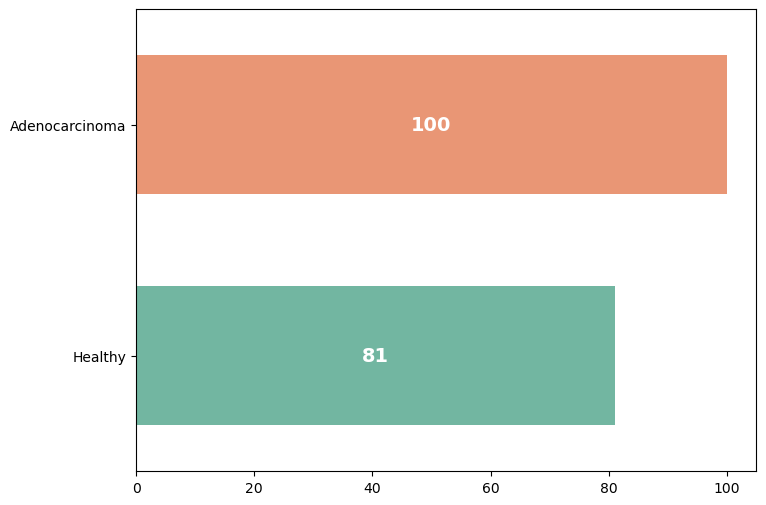

In [5]:
palette = sns.color_palette("Set2")

plt.figure(figsize=(8, 6))
sns.countplot(y=df.HealthState, data=df, width=0.6, order=df.HealthState.value_counts().index,
              palette=[palette[1], palette[0], palette[3]])
plt.xlabel("")

for index, value in enumerate(df.HealthState.value_counts()):
    plt.text(value / 2, index, str(value), color='white', fontweight='bold', fontsize=14,
                ha='center', va='center')     
plt.ylabel('')
plt.show()

### Volcano Plot

In [6]:
df_metabolites = df.drop(columns=['SampleType', 'SmokingStatus', 'Sex'])
df_metabolites['HealthState'] =  df['HealthState'].apply(lambda x: 1 if x in ['Adenocarcinoma'] else 0)

df_metabolites.columns = metabolites_names
print(df_metabolites.head())

   HealthState  xylose  xylitol  xanthine  valine  uridine  uric acid    urea  \
0            1     194      168        77  105985      118      15489  166416   
1            1     215      143       154  100462      133      13534   12818   
2            1     104       67        45   75301       94       7390  227147   
3            1     360      642        82   42097       84      50943   83452   
4            1      96      137        95  112346      168      41987   56353   

   tyrosine  tryptophan  ...  2-deoxytetronic acid  deoxythreittol NIST  \
0     42689       11493  ...                   195                 1606   
1     22282       24940  ...                   184                  364   
2     17624        6960  ...                   189                  157   
3     26447       12207  ...                   320                 1621   
4     41098       40802  ...                    84                  769   

   2-deoxyerythritol  2-aminoadipic acid  1,5-anhydroglucitol 

In [7]:
# Calcoliamo il fold change
fold_change = np.log2(df_metabolites.loc[df_metabolites['HealthState'] == 1].mean() / df_metabolites.loc[
    df_metabolites['HealthState'] == 0].mean())

# Calcoliamo il p-value
t_stat, p_value = stats.ttest_ind(df_metabolites.loc[df_metabolites['HealthState'] == 0],
                                  df_metabolites.loc[df_metabolites['HealthState'] == 1])
# Calcoliamo -log10(p_value)
log_p_value = -np.log10(p_value)

# Creiamo il DataFrame per il volcano plot
df_volcano = pd.DataFrame({'fold_change': fold_change, '-log10(p_value)': log_p_value})

/Users/nova/Programming/anaconda3/envs/thesis/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return result_to_tuple(hypotest_fun_out(*samples, **kwds))
/var/folders/dv/cqkd8q211lb6w_8jd__s86d40000gn/T/ipykernel_94057/1530867815.py:9: RuntimeWarning: divide by zero encountered in log10
  log_p_value = -np.log10(p_value)


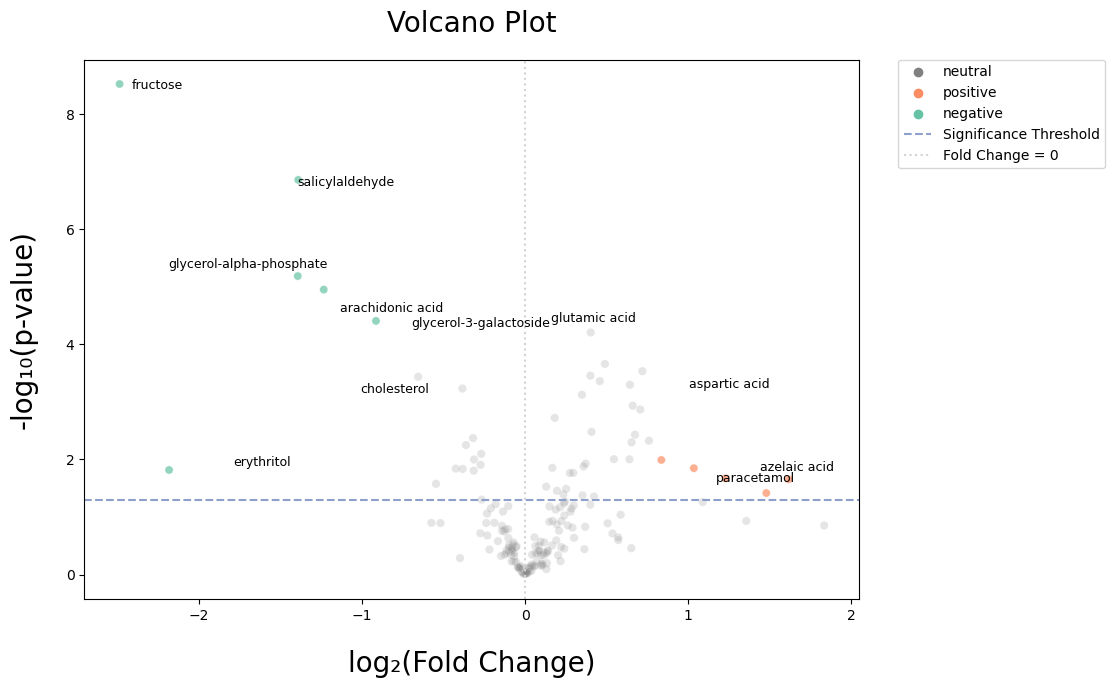

In [8]:
# Creiamo il volcano plot
plt.figure(figsize=(10, 7))

# Selezioniamo i principali metaboliti in base al valore assoluto del fold change e al filtro -log10(p-value)
df_volcano['abs_fold_change'] = abs(df_volcano['fold_change'])
df_volcano.dropna(inplace=True)
df_volcano.drop('HealthState', axis=0, inplace=True)

df_volcano['sort_score'] = (df_volcano['abs_fold_change'] * 3) + df_volcano['-log10(p_value)']

df_volcano['fold_change_sign'] = df_volcano['fold_change'].apply(
    lambda x: 'negative' if x < -.7 else 'positive' if x > .8 else 'neutral')

# fold_change_sign if -log10(p_value) > -np.log10(0.05) else 'neutral'
df_volcano['fold_change_sign'] = df_volcano.apply(
    lambda x: x['fold_change_sign'] if x['-log10(p_value)'] > -np.log10(0.05) else 'neutral', axis=1)

top_metabolites = df_volcano.sort_values(by=['sort_score'], ascending=False)
top_metabolites = top_metabolites.loc[top_metabolites['-log10(p_value)'] > -np.log10(0.05)]

# Scatter plot con fold change sull'asse x e -log10(p-value) sull'asse y, con colore differenziato per il fold change positivo o negativo
for color, sign in zip(['grey', palette[1], palette[0]], ['neutral', 'positive', 'negative']):
    sns.scatterplot(x='fold_change', y='-log10(p_value)', data=df_volcano[df_volcano['fold_change_sign'] == sign],
                    hue='fold_change_sign', palette=[color], alpha=color == 'grey' and 0.2 or 0.7)

plt.xlabel('log\u2082(Fold Change)', fontsize=20, labelpad=20)
plt.ylabel('-log\u2081\u2080(p-value)', fontsize=20, labelpad=20)
plt.title('Volcano Plot', fontsize=20, pad=20)

plt.axhline(y=-np.log10(0.05), linestyle='--', label='Significance Threshold', color=palette[2])
plt.axvline(x=0, linestyle=':', label='Fold Change = 0', color="lightgrey")
for index, row in top_metabolites.head(12).iterrows():
    plt.annotate(index,
                 (row['fold_change'] + np.random.normal(0, 0.3), row['-log10(p_value)'] + np.random.normal(0, 0.3)),
                 fontsize=9)


# Creiamo il boxplot per i metaboliti più significativi
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Jointplot

<Figure size 1000x700 with 0 Axes>

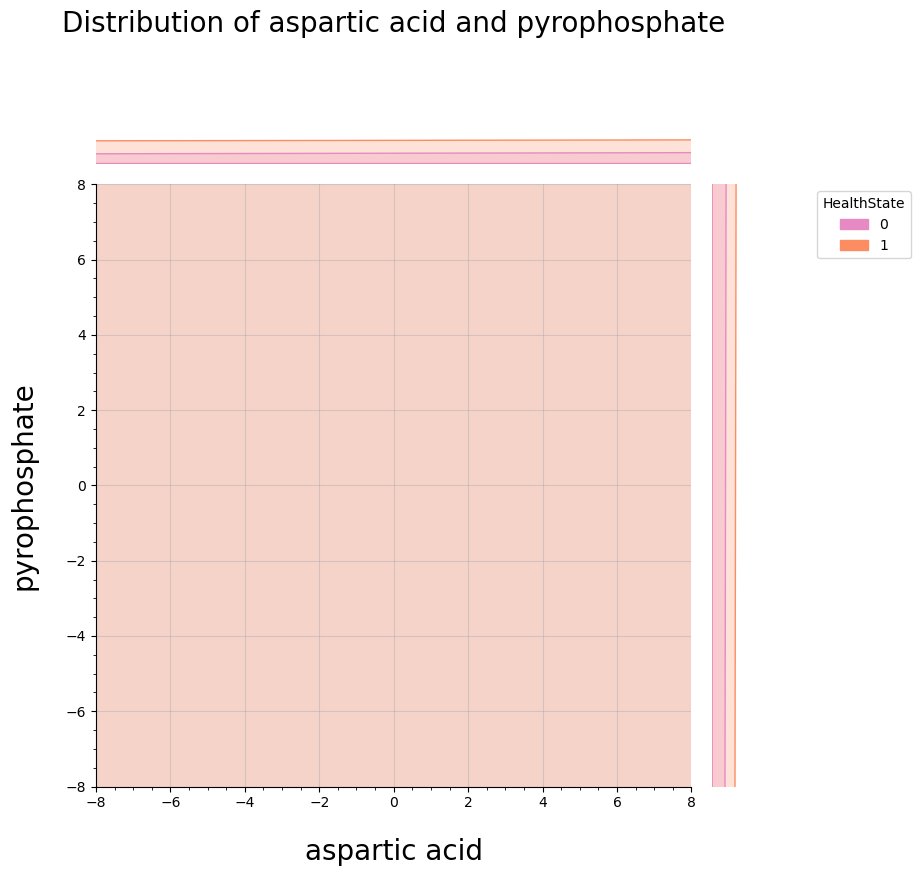

In [9]:
x = "aspartic acid"
y = "pyrophosphate"
z = "HealthState"

plt.figure(figsize=(10, 7))

plot = sns.jointplot(x=x, y=y, data=df_metabolites, hue=z, alpha=.6, height=8, palette=[palette[3], palette[1]],
                     kind='kde', fill=True, marginal_kws=dict(bw_adjust=.5, bw_method=.5))

plot.set_axis_labels(xlabel=x, ylabel=y)
plot.ax_marg_x.grid(False)
plot.ax_marg_y.grid(False)

plot.ax_marg_x.axis('off')
plot.ax_marg_y.axis('off')

plt.xlim(-8, 8)
plt.ylim(-8, 8)

plot.ax_joint.grid(alpha=0.5)

plot.ax_joint.minorticks_on()
sns.move_legend(plot.ax_joint, "upper left", bbox_to_anchor=(1.2, 1))
plot.ax_marg_x.set_title("Distribution of {} and {}".format(x, y), fontsize=20, pad=20)
plot.ax_joint.set_xlabel(x, fontsize=20, labelpad=20)
plot.ax_joint.set_ylabel(y, fontsize=20, labelpad=20)
plt.show()